# Audio Capture & Augmentation
#### Author: Jeromey Schwartz
#### *Audio capture code (indicated with *) supplied by Dr. Jeremy Holleman UNC-Charlotte 

### Purpose:
This will record an audio sample 1 second long at a sampling rate of 16kHz, the samples can then be augmented by adding noise, pitch shifting, or time shifting 

### Program Flow:
1. Load libraries/setup code 
2. Save a number of audio samples 
3. Save ambient noise samples 
4. Noise shift 
5. Time shift 
6. Pitch shift 
7. Save samples names in validation document 

#### Import libraries

In [3]:
import os
os.environ['PY_SSIZE_T_CLEAN'] = '1'

import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import numpy as np
import time
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob
from datetime import datetime as dt
from numpy import log as ln
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython
import IPython.display as ipd
import tensorflow as tf
%matplotlib inline
import pyaudio
from queue import Queue
from threading import Thread
import math
import time
import librosa

#### Set Parameters*

In [4]:
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
keyword        = 'computer'#####Insert your keyword
spectrogram_shape = (64, 24, 32, 1)

chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
sample_rate = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

#### Create keyword & noise folders*

In [6]:
import os

# Define the path to the parent directory
parent_dir = os.getcwd()
parent_dir = os.path.join(parent_dir, "data/custom-speech")

# Get the name of the current keyword
keyword = "computer"

# Create the folder name and path
folder = keyword
dir = os.path.join(parent_dir, folder)

# Create the directories if they do not exist
if not os.path.exists(dir):
    os.mkdir(dir)

folder = keyword
dir = os.path.join(parent_dir, folder)
noise_dir = os.path.join(parent_dir, "noise")

if not os.path.exists(dir):
    os.mkdir(dir)

if not os.path.exists(noise_dir):
    os.mkdir(noise_dir)

keyword_directory = dir + '/'
print(keyword_directory)

# Check if the directories were created
if os.path.exists(os.path.join(parent_dir, "computer")):
    print("Directory 'computer' created")
if os.path.exists(os.path.join(parent_dir, "noise")):
    print("Directory 'noise' created")


/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/computer/
Directory 'computer' created
Directory 'noise' created


# Get Custom Data

#### Run this code to get in an audio sample*

In [7]:
import pyaudio

# Create a PyAudio object
pa = pyaudio.PyAudio()

# Get the default input and output devices
default_input_device = pa.get_default_input_device_info()
default_output_device = pa.get_default_output_device_info()

# Print information about the default devices
print("Default input device:")
print(default_input_device)

print("\nDefault output device:")
print(default_output_device)

# # Print information about all available devices
# print("\nAvailable devices:")
# for i in range(pa.get_device_count()):
#     device_info = pa.get_device_info_by_index(i)
#     print(device_info)


Default input device:
{'index': 23, 'structVersion': 2, 'name': 'default', 'hostApi': 0, 'maxInputChannels': 32, 'maxOutputChannels': 32, 'defaultLowInputLatency': 0.008684807256235827, 'defaultLowOutputLatency': 0.008684807256235827, 'defaultHighInputLatency': 0.034807256235827665, 'defaultHighOutputLatency': 0.034807256235827665, 'defaultSampleRate': 44100.0}

Default output device:
{'index': 23, 'structVersion': 2, 'name': 'default', 'hostApi': 0, 'maxInputChannels': 32, 'maxOutputChannels': 32, 'defaultLowInputLatency': 0.008684807256235827, 'defaultLowOutputLatency': 0.008684807256235827, 'defaultHighInputLatency': 0.034807256235827665, 'defaultHighOutputLatency': 0.034807256235827665, 'defaultSampleRate': 44100.0}


ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'


In [8]:
import sys
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


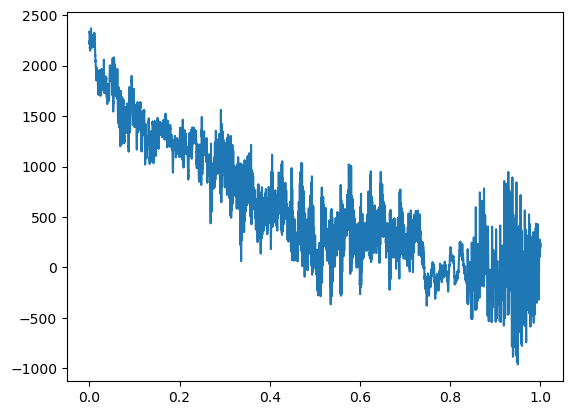

In [9]:
# Queue to communiate between the audio callback and main thread
q = Queue()
run = True
silence_threshold = 100
# Run the demo for a timeout seconds
timeout = time.time() + 1 
# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=23,
    stream_callback=callback)
stream.start_stream()
try:
    while run:        
        data = q.get()
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False      
stream.stop_stream()
stream.close()

sample_rate = fs


#Displaying wave file data
plt.plot(np.arange(1*fs)/fs, data)
plt.show()
ipd.Audio(data, rate=fs)

#### If the Sample looks good run cell below to save it 

In [ ]:
# #saving the wave file to training_data
date_str = dt.now().strftime("%H%M%S").lower()
current_name = f"{keyword_directory}{keyword}_{date_str}.wav".replace("\\", "/")
write(current_name, sample_rate, data)
print("Audio sample saved")
print(current_name)

#### Noise
* To get noise data run "get data" loop again to get ambient room
* Save here
* Get ~3 samples total

In [ ]:
# #saving the wave file to training_data
date_str = dt.now().strftime("%H%M%S").lower()
current_name = f"{parent_dir}/noise/noise_{date_str}.wav"
write(current_name, sample_rate, data)
print("Audio sample saved as noise")

# Audio Augmentation- Noise
    * This will create copies of sample audio and add pre-recorded noise. 
    * The amplitude of the noise depends on *noise_count*
    * Audio samples and visualizations are created to show noise augmentation

In [ ]:
#Selecting augmentation folder & files
data_dir = dir
print(data_dir)
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [ ]:
#Loading noise samples
noise_dir = parent_dir+'/noise'
noise_samples = tf.io.gfile.glob(str(noise_dir) + '/*.wav')
print("Noise Samples:", len(noise_samples))

#### Set Augment count

In [ ]:
#noise_count will deteremine how many augmentations will be created
    #noise_count=1 will be a copy with noise augmentation * 0
    #noise_count=2 will be noise_count=1 plus a copy with noise augmentation * 1
    #noise_count=2 will be noise_count=2 plus a copy with noise augmentation * 2  
    #and so on 

noise_count=4
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*len(noise_samples)*noise_count, "noise augmented files, to give a total of",len(filenames)*len(noise_samples)*(noise_count)+len(filenames),"files")

#### Creating Noise Augmentation

In [ ]:
#dict holds samples for plotting
noise_dict={}
for index in range(len(filenames)):
    test_wav=filenames[index]
    fs, test_wav = wavfile.read(test_wav)
    if (len(test_wav) < fs):
        padding=fs-len(test_wav)
        extra_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
        test_wav=np.concatenate((test_wav,extra_padding),axis=0).astype(np.int16)
    noise_dict[0]=test_wav.astype(np.int16)
    for i in range(len(noise_samples)):
        noise=noise_samples[i]
        fs, noise = wavfile.read(noise)
        for j in range(noise_count):
            noise_multiplier=round(max(test_wav)*(j/2000))
            noise_lvl=noise*noise_multiplier
            test_wave_with_noise=np.add(test_wav,noise_lvl)
            current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_Noise{i}_Multiplier{j}.wav"
            write(current_name, fs, test_wave_with_noise)
            noise_dict[j+1]=test_wave_with_noise.astype(np.int16)
            noise_dict[j+5]=noise_lvl.astype(np.int16)

#### Plotting noise augmenation

In [ ]:
#Only plots up to noise lvl 3
fig, axs = plt.subplots(4, 4,figsize=(20,10), sharex=True,sharey=True)
axs[0,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,1].plot(np.arange(1*fs)/fs, noise_dict[5], 'tab:orange')
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[5])
axs[0,3].plot(np.arange(1*fs)/fs, noise_dict[1])

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Noise")
axs[0, 2].set_title("Original + Noise")
axs[0, 3].set_title("Augmented Audio")

axs[0, 0].set(xlabel='Time (s)', ylabel='Noise lvl 0')
axs[1, 0].set(xlabel='Time (s)', ylabel='Noise lvl 1')
axs[2, 0].set(xlabel='Time (s)', ylabel='Noise lvl 2')
axs[3, 0].set(xlabel='Time (s)', ylabel='Noise lvl 3')

axs[1,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,1].plot(np.arange(1*fs)/fs, noise_dict[6], 'tab:orange')
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[6])
axs[1,3].plot(np.arange(1*fs)/fs, noise_dict[2])

axs[2,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,1].plot(np.arange(1*fs)/fs, noise_dict[7], 'tab:orange')
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[7])
axs[2,3].plot(np.arange(1*fs)/fs, noise_dict[3])

axs[3,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,1].plot(np.arange(1*fs)/fs, noise_dict[8], 'tab:orange')
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[8])
axs[3,3].plot(np.arange(1*fs)/fs, noise_dict[4])

for ax in axs.flat:
    ax.set(xlabel='Time (s)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Listen to noise augmenation

In [ ]:
#Only samples up to noise lvl 3
from IPython.display import Audio 
from IPython.display import display

print("Noise lvl 0:")
display(Audio(noise_dict[0], rate=fs))
print("Noise lvl 1:")
display(Audio(noise_dict[2], rate=fs))
print("Noise lvl 2:")
display(Audio(noise_dict[3], rate=fs))
print("Noise lvl 3:")
display(Audio(noise_dict[4], rate=fs))

# Audio Augmentation- Time Shift
    * This will create copies of sample audio and shift them forward or backward in time in 1/8s increments 
    * The "empty space" created by the time shift is filled with artificial noise (created in cell 12)

In [ ]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [ ]:
#initializing variables for 1/8th second time shifts
one_eighth=int((sample_rate/8)) #16k sample rate means 2k for 1/8s
padding=one_eighth #Number of samples to pad
#zero_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
noise_lvl_min=-200 #about the min for quiet room when measured with get audio code above
noise_lvl_max=200 #about the max for quiet room when measured with get audio code above
noise_padding=np.random.randint(noise_lvl_min,noise_lvl_max+1,padding) #makes random noise

#### Set Augment count

In [ ]:
#how many of each type of time shift is desired..in 1/8s increments
#suggest following bell curve with center being zero_shift and left_3/right_3 being the extremes

left_3=1
left_2=2
left_1=2
zero_shift=2
right_1=2
right_2=2
right_3=1

total=zero_shift+right_3+right_2+right_1+left_3+left_2+left_1

In [ ]:
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*total, "time shifted files, to give a total of",len(filenames)*(total+1),"files")

#### Time Shift Augment

In [ ]:
# Create a dictionary to hold audio for data visualization
audio_dict = {}

##This will randomize audio samples
#random_list = list(range(0, len(filenames))) #create array [1,2,3...]
#random.shuffle(random_list) #randomize the array

#This will reverse the list so the element printed in next cell shows augmentation to original sample
random_list = list(range(0, len(filenames))) #create array [1,2,3...]
random_list.reverse() #randomize the array

#creates dictionary to hold audio for data visualization
audio_dict={}

##This will randomize audio samples
#random_list = list(range(0, len(filenames))) #create array [1,2,3...]
#random.shuffle(random_list) #randomize the array

#This will reverse the list so the element printed in next cell shows augmentation to original sample
random_list = list(range(0, len(filenames))) #create array [1,2,3...]
random_list.reverse() #randomize the array

from tqdm import tqdm

#runs 5x shifts audio from original to left by .5sec in 1/8s increments
for index in tqdm(range(len(filenames)), desc="Augmenting audio"):
    test_wav=filenames[random_list[index]]
    fs, test_wav = wavfile.read(test_wav)
    audio_dict[0]=test_wav.astype(np.int16)#dict[0] holds original audio
    test_wav_decrease = test_wav #creating copy to be manipulated 
    test_wav_increase = test_wav #creating copy to be manipulated
    
    #shift audio to left in 1/8s increments
    for j in range(1,4):#dict 1-4 hold shifted audio (change 4 to 5 to make 1/2s shift)
        for i in range (one_eighth):
            test_wav_decrease=np.delete(test_wav_decrease,0)
        test_wav_decrease=np.concatenate((test_wav_decrease,noise_padding),axis=0).astype(np.int16)
        audio_dict[j]=test_wav_decrease.astype(np.int16)
        if (j==1):
            for p in range(left_1): #creates left_1 copys shifted left 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==2):
            for p in range(left_2): #creates left_2 copys shifted left 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==3):
            for p in range(left_3): #creates left_3 copy shifted left 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)

    
    #shift audio to right in 1/8s increments
    for k in range(6,9):
        #pad zeros to front
        test_wav_increase=np.concatenate((noise_padding,test_wav_increase),axis=0)
        #delete data past 16k samples
        for d in range(sample_rate,len(test_wav_increase)):
            test_wav_increase=np.delete(test_wav_increase,sample_rate,0).astype(np.int16)
        audio_dict[k]=test_wav_increase
        if (k==6):
            for p in range(right_1): #creates right_1 copys shifted right 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==7):
            for p in range(right_2): #creates right_2 copys shifted right 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==8):
            for p in range(right_3): #creates right_3 copy shifted right 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
    for l in range(zero_shift):
        current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_NoShift_{l}.wav"
        write(current_name, fs, test_wav)

#### Plot time shifted audio

In [ ]:
#commented out is for half second shift if desired

fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
# f_ax4 = fig.add_subplot(axs[2, 3])
f_ax6 = fig.add_subplot(axs[2, 0])
f_ax7 = fig.add_subplot(axs[2, 1])
f_ax8 = fig.add_subplot(axs[2, 2])
# f_ax9 = fig.add_subplot(axs[3, 3])

f_ax0.plot(np.arange(1*fs)/fs, audio_dict[0])
f_ax1.plot(np.arange(1*fs)/fs, audio_dict[1])
f_ax2.plot(np.arange(1*fs)/fs, audio_dict[2])
f_ax3.plot(np.arange(1*fs)/fs, audio_dict[3])
# f_ax4.plot(np.arange(1*fs)/fs, audio_dict[4])
f_ax6.plot(np.arange(1*fs)/fs, audio_dict[6])
f_ax7.plot(np.arange(1*fs)/fs, audio_dict[7])
f_ax8.plot(np.arange(1*fs)/fs, audio_dict[8])
# f_ax9.plot(np.arange(1*fs)/fs, audio_dict[9])

f_ax0.set_title('Original')
f_ax1.set_title('Shifted left 1/8')
f_ax2.set_title('Shifted left 1/4')
f_ax3.set_title('Shifted left 3/8')
# f_ax4.set_title('Shifted left 1/2')
f_ax6.set_title('Shifted right 1/8')
f_ax7.set_title('Shifted right 1/4')
f_ax8.set_title('Shifted right 3/8')
# f_ax9.set_title('Shifted right 1/2')
fig.set_size_inches(18.5, 10.5, forward=True)
pass

#### Listen to time shifted Audio

In [ ]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(audio_dict[0], rate=fs))
print("Shifted left 1/8:")
display(Audio(audio_dict[1], rate=fs))
print("Shifted left 1/4:")
display(Audio(audio_dict[2], rate=fs))
print("Shifted left 3/8:")
display(Audio(audio_dict[3], rate=fs))
# print("Shifted left 1/2:")
# display(Audio(audio_dict[4], rate=fs))
print("Shifted right 1/8:")
display(Audio(audio_dict[6], rate=fs))
print("Shifted right 1/4:")
display(Audio(audio_dict[7], rate=fs))
print("Shifted right 3/8:")
display(Audio(audio_dict[8], rate=fs))
# print("Shifted right 1/2:")
# display(Audio(audio_dict[9], rate=fs))

# Audio Augmentation- Pitch Shift
    * This will create copies of sample audio and pitch shift them
    * The variable *pitch_shift* allows control over pitch
    * The variable *desired_number_of_files* allows control of exactly how many samples to create
    * The loop will continue creating copies until desired count is reached, including pitch shifting already pitch shifted copies

In [ ]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [ ]:
print("The current number of files in directory is", len(filenames))

#### Set Augment count

In [ ]:
#STOPED AUGMENTING HERE

# Write augmented data files to testing and validation .txt file 

In [ ]:
print("Sample count:", len(filenames))

In [ ]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Verifying opens files correctly
print(filenames[0])

num_files=len(filenames)
num_files
print("Total files:", num_files)

#randomizes order of samples for validation list
random_list = list(range(0, num_files)) #create array [1,2,3...]
random.shuffle(random_list) #randomize the array

In [ ]:
import random
import os

# Set the random seed for reproducibility
random.seed(42)

# Set the paths and file names for the train, test, and validation files
train_file_name = './data/custom-speech/training_list.txt'
test_file_name = './data/custom-speech/testing_list.txt'
val_file_name = './data/custom-speech/validation_list.txt'

# Set the split percentages
train_pct = 0.7
test_pct = 0.2
val_pct = 0.1

# Get a list of all WAV files in the data directory
wav_files = tf.io.gfile.glob(str(data_dir) + '/*.wav')

# Shuffle the files randomly
random.shuffle(wav_files)

# Calculate the number of files for each split
num_files = len(wav_files)
num_train = int(train_pct*num_files)
num_test = int(test_pct*num_files)
num_val = num_files - num_train - num_test

# Create the train list file
with open(train_file_name, 'w') as f:
    for file in wav_files[:num_train]:
        f.write(os.path.join(keyword, os.path.basename(file)) + '\n')
print(num_train, "samples added to", train_file_name)

# Create the test list file
with open(test_file_name, 'w') as f:
    for file in wav_files[num_train:num_train+num_test]:
        f.write(os.path.join(keyword, os.path.basename(file)) + '\n')
print(num_test, "samples added to", test_file_name)

# Create the validation list file
with open(val_file_name, 'w') as f:
    for file in wav_files[num_train+num_test:]:
        f.write(os.path.join(keyword, os.path.basename(file)) + '\n')
print(num_val, "samples added to", val_file_name)

In [ ]:
# Set the paths and file names for the train, test, and validation files for "yes" folder
yes_train_file_name = './data/custom-speech/training_list.txt'
yes_test_file_name = './data/custom-speech/testing_list.txt'
yes_val_file_name = './data/custom-speech/validation_list.txt'

# Get a list of all WAV files in the "yes" folder
yes_wav_files = tf.io.gfile.glob(str('./data/custom-speech/') + '/yes/*.wav')
# Shuffle the files randomly
random.shuffle(yes_wav_files)

# Calculate the number of files for each split
yes_num_files = len(yes_wav_files)
yes_num_train = int(train_pct * yes_num_files)
yes_num_test = int(test_pct * yes_num_files)
yes_num_val = yes_num_files - yes_num_train - yes_num_test

# Create the train list file for "yes" folder
with open(yes_train_file_name, 'a') as f:  # use 'a' mode to append to file
    for file in yes_wav_files[:yes_num_train]:
        f.write(os.path.join('yes', os.path.basename(file)) + '\n')
print(yes_num_train, "samples added to", yes_train_file_name)

# Create the test list file for "yes" folder
with open(yes_test_file_name, 'a') as f:  # use 'a' mode to append to file
    for file in yes_wav_files[yes_num_train:yes_num_train+yes_num_test]:
        f.write(os.path.join('yes', os.path.basename(file)) + '\n')
print(yes_num_test, "samples added to", yes_test_file_name)

# Create the validation list file for "yes" folder
with open(yes_val_file_name, 'a') as f:  # use 'a' mode to append to file
    for file in yes_wav_files[yes_num_train+yes_num_test:]:
        f.write(os.path.join('yes', os.path.basename(file)) + '\n')
print(yes_num_val, "samples added to", yes_val_file_name)


In [ ]:
#How many of the files do you want to have total?
desired_number_of_files=1000

#How do you want to pitch shift
    #positive=high pitch, negative = low pitch
    #0.25 is a good value
pitch_shift=0.25

### Doubling Equation:   
> $output=input * 2^{x}$

*Here $x$ is the number of times input is doubled

#### To get desired number of output files from input when loop doubles input every iteration of the for loop we solve for $x$:
   
> $x=\log _{2}(\frac{out}{in})$\
  $x=\frac{\ln (\frac{out}{in})} {\ln (2)}$
                 
#### Next $math.ceil()$ is used to round up to integer for loop iteration

> $x=$ math.ceil$(\frac{\ln (out)}{\ln (in)})$

In [ ]:
#Doubling formula used to find range for outer for loop indexing with "i"
outer_range= math.ceil((np.log(desired_number_of_files / len(filenames)) / np.log(2) ))
outer_range

#### Pitch Augmentation

In [ ]:
#replace line 11 with comment below if you want to create a custom # < len(filenames)...
#                                                    ...comment out if statements and speed will improve significantly
#for index in range(40000): 

pitch_dict={}
for i in range(outer_range):
    for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        if i==0:
            pitch_dict[i]=test_wav
        test_wav_float=test_wav.astype(float)
        test_wav_pitch_shifted = librosa.effects.pitch_shift(test_wav_float, sr=sample_rate, n_steps=pitch_shift*(i+1))
        test_wav_pitch_shifted_int=test_wav_pitch_shifted.astype(np.int16)
        current_name = str(keyword_directory)+str(keyword) +f"_Pitch_Shift_{i}_{index}.wav"    
        write(current_name, fsamp, test_wav_pitch_shifted_int)

        files_in_folder=len(tf.io.gfile.glob(str(data_dir) + '/*.wav'))
        pitch_dict[i+1]=test_wav_pitch_shifted_int
        if (files_in_folder >= desired_number_of_files):
            break 
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    #update filenames with newly created files    
    if (files_in_folder >= desired_number_of_files):
        break 
print("Congratulations, the current number of files in directory is", len(filenames))

#### Plot Pitch Shift

In [ ]:
fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
f_ax4 = fig.add_subplot(axs[2, 0])
f_ax5 = fig.add_subplot(axs[2, 1])
f_ax6 = fig.add_subplot(axs[2, 2])

f_ax0.plot(np.arange(1*fs)/fs, pitch_dict[0])
f_ax0.set_title('Original')

if outer_range>1:
    f_ax1.plot(np.arange(1*fs)/fs, pitch_dict[1])
    f_ax1.set_title('Pitch Shift lvl 1')
if outer_range>2:
    f_ax2.plot(np.arange(1*fs)/fs, pitch_dict[2])
    f_ax2.set_title('Pitch Shift lvl 2')
if outer_range>3:
    f_ax3.plot(np.arange(1*fs)/fs, pitch_dict[3])
    f_ax3.set_title('Pitch Shift lvl 3')
if outer_range>4:
    f_ax4.plot(np.arange(1*fs)/fs, pitch_dict[4])
    f_ax4.set_title('Pitch Shift lvl 4')
if outer_range>5:
    f_ax5.plot(np.arange(1*fs)/fs, pitch_dict[5])
    f_ax5.set_title('Pitch Shift lvl 5')
if outer_range>6:
    f_ax6.plot(np.arange(1*fs)/fs, pitch_dict[6])
    f_ax6.set_title('Pitch Shift lvl 6')

fig.set_size_inches(18.5, 10.5, forward=True)
pass

#### Listen to Pitch Shift

In [ ]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(pitch_dict[0], rate=fs))

if outer_range>1:
    print("Pitch Shift lvl 1")
    display(Audio(pitch_dict[1], rate=fs))
if outer_range>2:
    print("Pitch Shift lvl 2")
    display(Audio(pitch_dict[2], rate=fs))
if outer_range>3:
    print("Pitch Shift lvl 3")
    display(Audio(pitch_dict[3], rate=fs))
if outer_range>4:
    print("Pitch Shift lvl 4")
    display(Audio(pitch_dict[3], rate=fs))
if outer_range>5:
    print("Pitch Shift lvl 5")
    display(Audio(pitch_dict[4], rate=fs))
if outer_range>6:
    print("Pitch Shift lvl 6")
    display(Audio(pitch_dict[5], rate=fs))

# Additional Augmentations
    *These change volume
    *Still needs work, suggest staying with previous augmentations

In [ ]:
#load data
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [ ]:
print("Sample count:", len(filenames))

#### Icrease audio sample amplitude by multiplier

In [ ]:
#Increases existing audios volume/amplitue 
multiplier=3
for i in range(1,multiplier):
    for index in range(len(filenames)):
            test_wav=filenames[index]
            fs, test_wav = wavfile.read(test_wav)
            sound=test_wav*(i)
            sound_normalized=sound.astype(np.int16)
            current_name = str(keyword_directory) + str(keyword)+f"noiseLVL_{i}_{index}.wav" 
            write(current_name, fsamp, sound_normalized)

data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
print("Multiplier complete")
print("Sample count:", len(filenames))

In [ ]:
test_wav=filenames[250]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

#### Normalize to specific amplitude level

In [ ]:
noise_level=12000
for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        sound = test_wav*(noise_level/max(test_wav))
        sound_normalized=sound.astype(np.int16)
        current_name = str(keyword_directory) + str(keyword)+f"_{index}.wav" 
        #current_name = filenames[index]
        write(current_name, fsamp, sound_normalized)
        if ((index%10)==0):
            print(f"{index}/{len(filenames)} complete")

In [ ]:
test_wav=filenames[250]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)